In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

import os

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [ ]:
%cd /kaggle

/kaggle


In [ ]:
!kaggle datasets download -d eislax/fresh-and-rotten-fruit-dataset-4fruit

Dataset URL: https://www.kaggle.com/datasets/eislax/fresh-and-rotten-fruit-dataset-4fruit
License(s): Apache 2.0
100% 2.74G/2.75G [00:32<00:00, 72.0MB/s]
100% 2.75G/2.75G [00:32<00:00, 90.4MB/s]


In [ ]:
!unzip fresh-and-rotten-fruit-dataset-4fruit.zip -d dataset-fruitsnap

Streaming output truncated to the last 5000 lines.
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/997.jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (103).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (104).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (105).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (112).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (113).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (114).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (115).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (116).jpg  
  inflating: dataset-fruitsnap/dataset_fix/train/rottenstrawberry/rottenStrawberries (117).jpg  


In [ ]:
train_dir = "/kaggle/dataset-fruitsnap/dataset_fix/train"
test_dir = "/kaggle/dataset-fruitsnap/dataset_fix/test"
val_dir = "/kaggle/dataset-fruitsnap/dataset_fix/val"

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

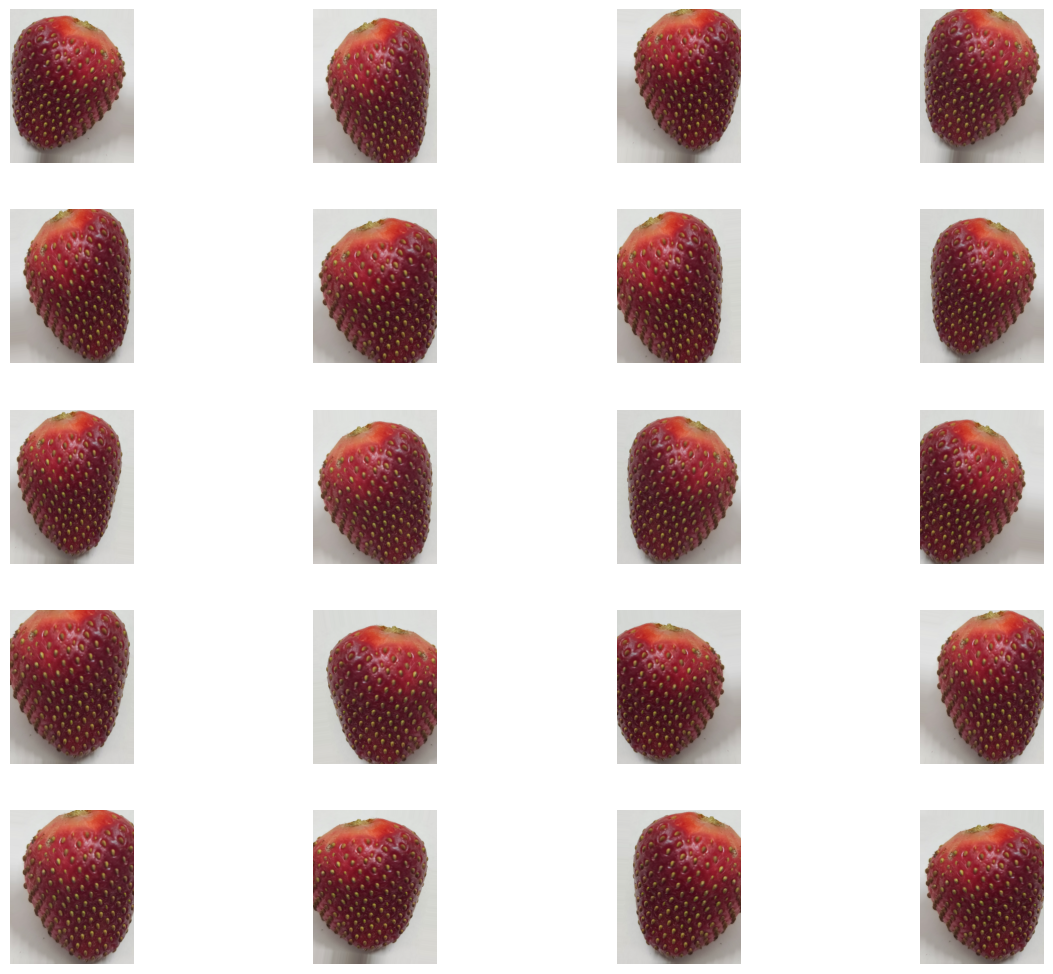

In [ ]:
# Memuat gambar untuk augmentasi dari train_dir
sample_category = os.listdir(train_dir)[0]  # Mengambil kategori pertama di train_dir
sample_image_path = os.path.join(train_dir, sample_category, os.listdir(os.path.join(train_dir, sample_category))[-1])
img_augmentation = image.load_img(sample_image_path)
x_aug = image.img_to_array(img_augmentation)
x_aug = x_aug.reshape((1,) + x_aug.shape)

# Menghasilkan gambar yang diaugmentasi
augmented_images = []
i = 0
for batch in train_datagen.flow(x_aug, batch_size=1):
    augmented_images.append(image.array_to_img(batch[0]))
    i += 1
    if i >= 20:
        break

# Menampilkan gambar-gambar yang diaugmentasi
plt.figure(figsize=(15, 15))
for n in range(len(augmented_images)):
    plt.subplot((len(augmented_images) // 4) + 1, 4, n + 1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(augmented_images[n])
    plt.axis('off')
plt.show()

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    color_mode="rgb",
                                                    target_size=(150,150),
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(val_dir,
                                                         batch_size=64,
                                                         color_mode="rgb",
                                                         target_size=(150,150),
                                                         class_mode='categorical')

num_classes = len(train_generator.class_indices)

Found 9183 images belonging to 8 classes.
Found 4537 images belonging to 8 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get(('loss') and ('val_loss') == 0.07)):
      print("\nReached be accuracy. Stop Training")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
# Model InceptionV3 yang sudah pre-trained
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Membekukan semua layer pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

# Menambahkan lapisan kustom di atas model pre-trained
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(8, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

# Mengompilasi model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d_4[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
model.fit(
    train_generator,
    # steps_per_epoch=(train_len/32),
    epochs= 10,
    verbose=1,
    callbacks=[callbacks],
    validation_data=validation_generator
    # validation_steps=(val_len/32)
)

Epoch 1/10
144/144 [==============================] - 186s 1s/step - loss: 7.6157 - accuracy: 0.7914 - val_loss: 0.4468 - val_accuracy: 0.9026
Epoch 2/10
144/144 [==============================] - 137s 950ms/step - loss: 0.7156 - accuracy: 0.8918 - val_loss: 0.4496 - val_accuracy: 0.9202
Epoch 3/10
144/144 [==============================] - 134s 934ms/step - loss: 0.4405 - accuracy: 0.9111 - val_loss: 0.4104 - val_accuracy: 0.9054
Epoch 4/10
144/144 [==============================] - 135s 941ms/step - loss: 0.3644 - accuracy: 0.9212 - val_loss: 0.2413 - val_accuracy: 0.9442
Epoch 5/10
144/144 [==============================] - 135s 937ms/step - loss: 0.3507 - accuracy: 0.9320 - val_loss: 0.1604 - val_accuracy: 0.9508
Epoch 6/10
144/144 [==============================] - 133s 929ms/step - loss: 0.2878 - accuracy: 0.9358 - val_loss: 0.2330 - val_accuracy: 0.9396
Epoch 7/10
144/144 [==============================] - 134s 930ms/step - loss: 0.2803 - accuracy: 0.9402 - val_loss: 0.1647 - va

In [ ]:
### Fine Tuning Model

In [ ]:
# Unfreeze the top layers of the pre-trained model
for layer in pre_trained_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    # steps_per_epoch=(train_len/32),
    epochs= 10,
    verbose=1,
    callbacks=[callbacks],
    validation_data=validation_generator
    # validation_steps=(val_len/32)
)

Epoch 1/10
144/144 [==============================] - 180s 1s/step - loss: 0.1690 - accuracy: 0.9574 - val_loss: 0.1083 - val_accuracy: 0.9676
Epoch 2/10
144/144 [==============================] - 134s 935ms/step - loss: 0.1370 - accuracy: 0.9632 - val_loss: 0.0928 - val_accuracy: 0.9742
Epoch 3/10
144/144 [==============================] - 136s 946ms/step - loss: 0.1220 - accuracy: 0.9679 - val_loss: 0.0867 - val_accuracy: 0.9713
Epoch 4/10
144/144 [==============================] - 133s 929ms/step - loss: 0.1124 - accuracy: 0.9701 - val_loss: 0.0978 - val_accuracy: 0.9727
Epoch 5/10
144/144 [==============================] - 138s 959ms/step - loss: 0.0967 - accuracy: 0.9716 - val_loss: 0.0916 - val_accuracy: 0.9751
Epoch 6/10
144/144 [==============================] - 137s 957ms/step - loss: 0.1035 - accuracy: 0.9711 - val_loss: 0.0714 - val_accuracy: 0.9773
Epoch 7/10
144/144 [==============================] - 138s 960ms/step - loss: 0.0939 - accuracy: 0.9703 - val_loss: 0.0758 - va

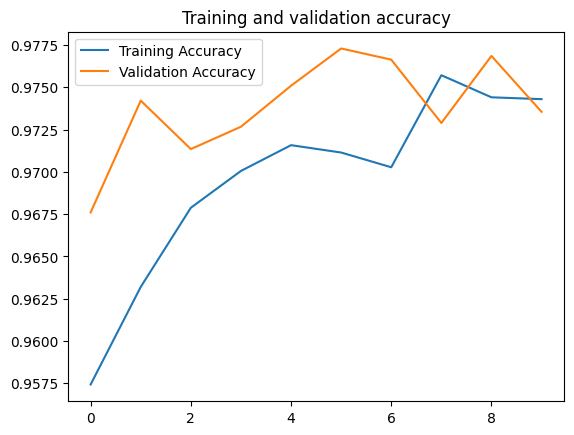

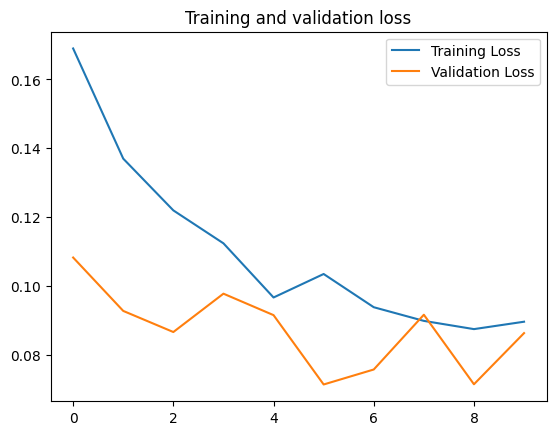

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy' ]
val_acc = history.history['val_accuracy' ]
loss = history.history['loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(acc))

# Plot training and validation accuracy
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=32,
                                                  target_size=(150, 150),
                                                  shuffle = False,
                                                  class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)

Found 3478 images belonging to 8 classes.
 109/3478 [..............................] - ETA: 13:07 - loss: 0.0602 - accuracy: 0.9833

3478/3478 [==============================] - 28s 7ms/step - loss: 0.0602 - accuracy: 0.9833
accuracy test:  0.9833237528800964


In [ ]:
model.save('model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_predict = tf.keras.models.load_model('/kaggle/model/model.h5')

Saving AR1.jpg to AR1.jpg
Saving AR2.jpg to AR2.jpg
Saving Fresh Fruit.jpg to Fresh Fruit.jpg
Saving freshappleramean.jpg to freshappleramean.jpg
Saving freshbananaagareamean.jpg to freshbananaagareamean.jpg
Saving freshbananaramean.jpg to freshbananaramean.jpg
Saving freshstraw.jpg to freshstraw.jpg
Saving images.jpg to images.jpg
Saving jerukbusukndirian.jpg to jerukbusukndirian.jpg
Saving jerukramean.jpg to jerukramean.jpg
Saving rottenapple.jpg to rottenapple.jpg
Saving rottenStraw.jpg to rottenStraw.jpg
Saving rottenstrawRAME.jpg to rottenstrawRAME.jpg
Saving strawberry-busuk-3jpg.jpg to strawberry-busuk-3jpg.jpg
Saving strawberry-fresh.jpg to strawberry-fresh.jpg
Saving tes-rotten-apple.png to tes-rotten-apple.png
1/1 [==============================] - 3s 3s/step
Predicted class: rottenapples, Accuracy: 100.00%


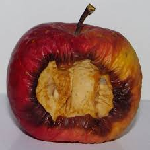

1/1 [==============================] - 0s 29ms/step
Predicted class: rottenapples, Accuracy: 99.96%


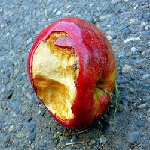

1/1 [==============================] - 0s 27ms/step
Predicted class: freshstrawberry, Accuracy: 54.32%


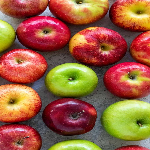

1/1 [==============================] - 0s 26ms/step
Predicted class: freshapples, Accuracy: 97.08%


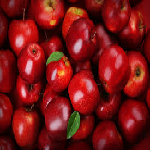

1/1 [==============================] - 0s 26ms/step
Predicted class: freshbanana, Accuracy: 100.00%


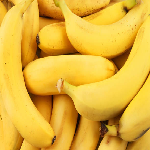

1/1 [==============================] - 0s 26ms/step
Predicted class: freshbanana, Accuracy: 100.00%


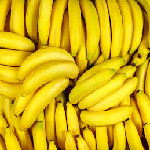

1/1 [==============================] - 0s 26ms/step
Predicted class: freshstrawberry, Accuracy: 65.74%


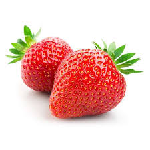

1/1 [==============================] - 0s 27ms/step
Predicted class: rottenbanana, Accuracy: 100.00%


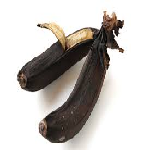

1/1 [==============================] - 0s 25ms/step
Predicted class: rottenoranges, Accuracy: 100.00%


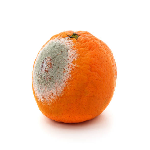

1/1 [==============================] - 0s 26ms/step
Predicted class: freshoranges, Accuracy: 100.00%


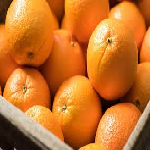

1/1 [==============================] - 0s 25ms/step
Predicted class: rottenapples, Accuracy: 100.00%


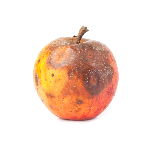

1/1 [==============================] - 0s 25ms/step
Predicted class: rottenstrawberry, Accuracy: 99.81%


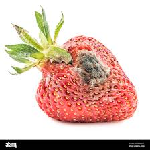

1/1 [==============================] - 0s 27ms/step
Predicted class: freshstrawberry, Accuracy: 81.48%


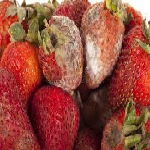

1/1 [==============================] - 0s 26ms/step
Predicted class: rottenstrawberry, Accuracy: 99.98%


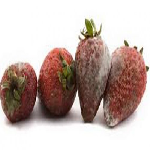

1/1 [==============================] - 0s 26ms/step
Predicted class: freshstrawberry, Accuracy: 99.91%


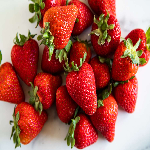

1/1 [==============================] - 0s 26ms/step
Predicted class: rottenapples, Accuracy: 100.00%


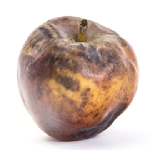

In [ ]:
import numpy as np
from google.colab import files

# Unggah file gambar
uploaded = files.upload()

# Loop untuk setiap file yang diunggah
for fn in uploaded.keys():
    # Praproses gambar
    img = image.load_img(fn, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalisasi gambar

    # Prediksi
    prediction = model_predict.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    # Menampilkan hasil prediksi
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class[0]]
    accuracy = prediction[0][predicted_class[0]] * 100
    print(f"Predicted class: {predicted_label}, Accuracy: {accuracy:.2f}%")
    display(img)


In [ ]:
# from keras.utils import get_file
# import cv2
# import math
# import numpy as np
# import matplotlib.pyplot as plt
# import os

# uploaded = files.upload()
# image_name = []
# image_conf = []
# predict_result = []

# # Tentukan kelas sesuai dengan urutan dalam dataset
# classes = ['Fresh Apple', 'Fresh Banana', 'Fresh Orange', 'Fresh Strawberry',
#            'Rotten Apple', 'Rotten Banana', 'Rotten Orange', 'Rotten Strawberry']

# for fn in uploaded.keys():
#     path = fn
#     img = cv2.imread(path)
#     img = cv2.resize(img, (150, 150))
#     img = img / 255.0  # Normalisasi

#     # Memperoleh prediksi dari model
#     pred = model_predict.predict(np.expand_dims(img, axis=0))
#     predicted_class = np.argmax(pred)
#     confidence = np.max(pred)

#     predict_result.append(classes[predicted_class])
#     image_name.append(fn)
#     image_conf.append(confidence)

# # Menampilkan hasil prediksi
# plt.figure(figsize=(15, 15))
# for i in range(len(image_name)):
#     plt.subplot(math.ceil(len(image_name) / 4) + 1, 4, i + 1)
#     plt.subplots_adjust(hspace=0.3)

#     # Mengonversi warna gambar dari BGR ke RGB
#     img_rgb = cv2.cvtColor(cv2.imread(image_name[i]), cv2.COLOR_BGR2RGB)

#     plt.imshow(img_rgb)
#     title = f"predict: {predict_result[i]} ({round(float(image_conf[i]) * 100, 2)}%)"
#     plt.title(title, color='black')
#     plt.axis('off')
# plt.show()

# # Menghapus gambar yang diunggah
# for fn in image_name:
#     os.remove(fn)


In [ ]:
# import numpy as np
# from google.colab import files
# import math

# # Daftar kelas sesuai dengan urutan folder dalam dataset (diambil dari train_generator)
# class_labels = list(train_generator.class_indices.keys())

# uploaded = files.upload()
# image_name = []
# image_conf = []
# predict_result = []

# for fn in uploaded.keys():
#     # Praproses gambar
#     img = image.load_img(fn, target_size=(150, 150))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array = img_array / 255.0  # Normalisasi gambar

#     # Prediksi
#     prediction = model_predict.predict(img_array)
#     predicted_class = np.argmax(prediction, axis=1)

#     # Menambahkan hasil prediksi ke daftar
#     predict_result.append(class_labels[predicted_class[0]])
#     image_name.append(fn)
#     image_conf.append(prediction[0][predicted_class[0]])

# # Menampilkan hasil prediksi
# plt.figure(figsize=(15, 15))
# for i in range(len(image_name)):
#     plt.subplot(math.ceil(len(image_name) / 4) + 1, 4, i + 1)
#     plt.subplots_adjust(hspace=0.3)

#     # Mengonversi warna gambar dari BGR ke RGB (hanya jika menggunakan cv2 untuk baca gambar)
#     img_rgb = image.load_img(image_name[i], target_size=(150, 150))

#     plt.imshow(img_rgb)
#     title = f"predict: {predict_result[i]} ({round(float(image_conf[i]) * 100, 2)}%)"
#     plt.title(title, color='black')
#     plt.axis('off')
# plt.show()

# # Menghapus gambar yang diunggah
# for fn in image_name:
#     os.remove(fn)
